## Michelle Campoli
mec2308 \
ELEN 4720: Machine Learning for Signals, Information and Data \
Homework 3

## Question 1

In [ ]:
# set up google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


READ_ME:

The following files are included:

1. ratings.csv contains the ratings data in the format: user_id, movie_id, rating

2. ratings_test.csv contains the test set with ground truth in the same format as ratings.txt.

3. movies.txt contains the mapping from movie_id to movie name. Row j corresponds to index j of movie_id.

4. README (original) is the original readme for the MovieLens 100K data set

Comment: I have subtracted the mean from the ratings. No other pre-processing is necessary.


MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:

*   100,000 ratings (1-5) from 943 users on 1682 movies.
*   Each user has rated at least 20 movies.
*   Simple demographic info for the users (age, gender, occupation, zip

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math as math
import datetime as dt 

In [ ]:
# import files
filepath = '/content/drive/MyDrive/ELENE4720_ML_Signals/Homework_3/hw3-data/'
ratings = pd.read_csv(filepath+'Prob1_ratings.csv', header = None)

# make M matrix : user_id x movie_id
new_ratings = ratings.rename(columns={0: 'user_id', 1: 'movie_id', 2: 'rating'})
wide_ratings = new_ratings.pivot(index='user_id', columns='movie_id', values='rating')
wide_ratings

movie_id,1,2,3,4,5,6,7,8,9,10,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.46960,-0.53039,0.46961,-0.53039,-0.53039,1.4696,0.46961,-2.5304,1.46960,-0.53039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.46961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.53040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.46961,-0.53039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.46960,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,-1.53040,NaN,NaN,0.46961,1.4696,-0.53039,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,1.46960,NaN,NaN,NaN,NaN,NaN,0.46961,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# there are no 0's in the dataframe
(wide_ratings == 0).sum().sum()

0

In [ ]:
# so set Nan to 0, these will be the empty parts of the matrix (sparse)
wide_ratings = wide_ratings.replace(np.nan,0)
# check if removed all nans
(wide_ratings == np.nan).sum().sum()

0

In [ ]:
(wide_ratings != 0).sum().sum()

95000

In [ ]:
# take 1
#this took literally forever and did not converge well at all

class MF():

    def __init__(self, R, K, alpha, lmbda, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-movie rating matrix
        - K (int)       : number of latent factors
        - alpha (float) : learning rate
        - lmbda (float) : parameter for grad descent
        - beta (float)  : regularization parameter
        """

        self.R = R.to_numpy()
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.lmbda = lmbda
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        self.P = np.random.normal(loc=0, scale=1, size=(self.num_users, self.K))
        self.Q = np.random.normal(loc=0, scale=1, size=(self.num_items, self.K))


        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] != 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []

        for i in range(self.iterations):
          self.gd()
          obj_fxn = self.objective_function()
          training_process.append(obj_fxn)
          if (i+1) % 100 == 0:
              print("Iteration: %d ; objective_function = %.4f" % (i+1, obj_fxn))

        return training_process

    def objective_function(self):
        """
        A function to compute the objective_function
        xs : row
        ys : column
        """
        predicted = self.full_matrix()
        e = predicted - self.R  
        
        return (np.trace(np.dot(e.T, e))/2) + self.lmbda*(np.linalg.norm(self.P) ** 2) +  self.lmbda*(np.linalg.norm(self.Q) ** 2)

    def gd(self):
        """
        Perform graident descent via dot product
        Take gradient
        """
            # Make predictions 
        predictions = []

        for i, j, r in self.samples:
          prediction = self.get_rating(i, j)
          predictions.append(prediction)

        samples_df = pd.DataFrame(self.samples)
        predicted_mat = samples_df[samples_df.columns[[0,1]]]
        predicted_mat['prediction'] = predictions
        wide_predicted = predicted_mat.pivot(index=0, columns=1, values='prediction')
        wide_predicted = wide_predicted.replace(np.nan,0)

            # Compute gradient
        e = (wide_predicted - self.R)
        grad_P = np.dot(e,self.Q) 
        grad_Q = np.dot(self.P.T,e)

            # Update user and movie item latent feature matrices
        self.P = self.P - self.alpha * (grad_P)
        self.Q = self.Q - self.alpha * (grad_Q).T

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j is simply 
        """
        prediction = self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Compute the full matrix using the resultant biases, P and Q
        """
        return self.P.dot(self.Q.T)

In [ ]:
# take 2
# try using GPU
# doesnt work :(
import torch

class MF():

    def __init__(self, R, K, alpha, lmbda, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-movie rating matrix
        - K (int)       : number of latent factors
        - alpha (float) : learning rate
        - lmbda (float) : parameter for grad descent
        """

        self.R = torch.tensor(R.to_numpy()).to(torch.device('cuda'))  # convert to PyTorch tensor and move to GPU
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.lmbda = lmbda
        self.iterations = iterations

        # Initialize user and item latent feature matrices
        self.P = torch.randn(self.num_users, self.K, device='cuda')  # move to GPU
        self.Q = torch.randn(self.num_items, self.K, device='cuda')  # move to GPU

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] != 0
        ]

    def train(self):
        training_process = []

        for i in range(self.iterations):
            self.gd()
            obj_fxn = self.objective_function()
            training_process.append(obj_fxn)
            if (i+1) % 100 == 0:
                print("Iteration: %d ; objective_function = %.4f" % (i+1, obj_fxn))

        return training_process

    def objective_function(self):
        """
        A function to compute the objective_function
        xs : row
        ys : column
        """
        predicted = self.full_matrix()
        e = predicted - self.R  
        
        return (torch.trace(torch.mm(e.t(), e))/2) + self.lmbda*(torch.norm(self.P) ** 2) +  self.lmbda*(torch.norm(self.Q) ** 2)

    def gd(self):
        """
        Perform graident descent via dot product
        Take gradient
        """
            # Make predictions 
        predictions = []

        for i, j, r in self.samples:
          prediction = self.get_rating(i, j)
          predictions.append(prediction)

        samples_df = pd.DataFrame(self.samples)
        predicted_mat = samples_df[samples_df.columns[[0,1]]]
        predicted_mat['prediction']

        predicted_mat['prediction'] = predictions
        wide_predicted = predicted_mat.pivot(index=0, columns=1, values='prediction')
        wide_predicted = wide_predicted.replace(np.nan,0)
        wide_predicted = torch.tensor(wide_predicted.to_numpy()).to(torch.device('cuda'))

            # Compute gradient
        e = (wide_predicted - self.R)
        grad_P = np.dot(e,self.Q) + self.lmbda*self.P
        grad_Q = np.dot(self.P.T,e) + self.lmbda*self.Q.T

            # Update user and movie item latent feature matrices
        self.P = self.P - self.alpha * (grad_P)
        self.Q = self.Q - self.alpha * (grad_Q).T

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j is simply 
        """
        prediction = self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Compute the full matrix using the resultant biases, P and Q
        """
        return self.P.dot(self.Q.T)

In [ ]:
# take 3
#try a regular python function


def mf(R, k, iterations, lr, lmbda):
  """
  Perform matrix factorization to predict empty
  entries in a matrix.

  Arguments
  - R (ndarray)   : user-movie rating matrix
  - k (int)       : number of latent factors
  - lr (float) : learning rate
  - lmbda (float) : regularization parameter
  """

  R = R.to_numpy() # switch from dataframe to numpy for faster compute
  num_users, num_items = R.shape

  samples = [ (i, j, R[i, j])
            for i in range(num_users)
            for j in range(num_items)
            if R[i, j] != 0 ]


  P = np.random.normal(loc=0, scale=1, size=(num_users, k))
  Q = np.random.normal(loc=0, scale=1, size=(num_items, k))

  objective_fxn = []
  it = []

  for epoch in range(iterations):
    it.append(epoch)

    # Update weights by gradients.
    for m in range(0,len(samples)):
      user,movie,rating = samples[m]
      err_ui = P[user,:].dot(Q[movie,:]) - rating

      for j in range(k):
        P[user][j] += -lr * (err_ui * Q[movie][j])
        Q[movie][j] += -lr * (P[user][j].T * err_ui).T

    # compute the loss
    full_matrix = P.dot(Q.T)
    error = np.zeros_like(R)
    for i in range(num_users):
      for j in range(num_items):
        if R[i,j] != 0:
          error[i,j] = full_matrix[i,j] - R[i,j]
        else:
          error[i,j] = 0
    
    loss = np.trace(np.dot(error.T, error))*0.5
    phi = loss + lmbda*(np.linalg.norm(P) ** 2) +  lmbda*(np.linalg.norm(Q) ** 2)
    objective_fxn.append(phi)
    if (epoch+1) % 10 == 0:
      print("Iteration: %d ; objective_function = %.4f" % (epoch+1, phi))

  return it, objective_fxn, full_matrix, P, Q

In [ ]:
it1, objective_fxn1, full_matrix1, P_end1, Q_end1  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)


Iteration: 10 ; objective_function = 67079.6679
Iteration: 20 ; objective_function = 57601.2380
Iteration: 30 ; objective_function = 51547.8793
Iteration: 40 ; objective_function = 47206.1377
Iteration: 50 ; objective_function = 44037.4835
Iteration: 60 ; objective_function = 41659.3615
Iteration: 70 ; objective_function = 39837.7513
Iteration: 80 ; objective_function = 38413.5089
Iteration: 90 ; objective_function = 37275.3857
Iteration: 100 ; objective_function = 36343.8084
Iteration: 110 ; objective_function = 35563.1111
Iteration: 120 ; objective_function = 34895.3478
Iteration: 130 ; objective_function = 34314.6491
Iteration: 140 ; objective_function = 33803.0029
Iteration: 150 ; objective_function = 33347.4918
Iteration: 160 ; objective_function = 32938.5522
Iteration: 170 ; objective_function = 32568.8745
Iteration: 180 ; objective_function = 32232.7085
Iteration: 190 ; objective_function = 31925.4263
Iteration: 200 ; objective_function = 31643.2471
Iteration: 210 ; objective_fu

In [ ]:
it2, objective_fxn2, full_matrix2, P_end2, Q_end2  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)


Iteration: 10 ; objective_function = 67251.9398
Iteration: 20 ; objective_function = 58578.1026
Iteration: 30 ; objective_function = 52878.1173
Iteration: 40 ; objective_function = 48314.3627
Iteration: 50 ; objective_function = 44735.3823
Iteration: 60 ; objective_function = 42011.3078
Iteration: 70 ; objective_function = 39964.1633
Iteration: 80 ; objective_function = 38398.3800
Iteration: 90 ; objective_function = 37171.3415
Iteration: 100 ; objective_function = 36188.3143
Iteration: 110 ; objective_function = 35385.2698
Iteration: 120 ; objective_function = 34717.4173
Iteration: 130 ; objective_function = 34152.6818
Iteration: 140 ; objective_function = 33667.7535
Iteration: 150 ; objective_function = 33245.4720
Iteration: 160 ; objective_function = 32873.0359
Iteration: 170 ; objective_function = 32540.7773
Iteration: 180 ; objective_function = 32241.3229
Iteration: 190 ; objective_function = 31969.0092
Iteration: 200 ; objective_function = 31719.4618
Iteration: 210 ; objective_fu

In [ ]:
it3, objective_fxn3, full_matrix3, P_end3, Q_end3  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)

Iteration: 10 ; objective_function = 66610.5269
Iteration: 20 ; objective_function = 56903.7584
Iteration: 30 ; objective_function = 51080.3163
Iteration: 40 ; objective_function = 46895.6380
Iteration: 50 ; objective_function = 43792.2532
Iteration: 60 ; objective_function = 41489.4918
Iteration: 70 ; objective_function = 39742.6500
Iteration: 80 ; objective_function = 38377.5896
Iteration: 90 ; objective_function = 37280.0695
Iteration: 100 ; objective_function = 36375.2765
Iteration: 110 ; objective_function = 35613.2812
Iteration: 120 ; objective_function = 34959.8773
Iteration: 130 ; objective_function = 34391.0340
Iteration: 140 ; objective_function = 33889.5220
Iteration: 150 ; objective_function = 33442.7772
Iteration: 160 ; objective_function = 33041.4789
Iteration: 170 ; objective_function = 32678.5725
Iteration: 180 ; objective_function = 32348.5927
Iteration: 190 ; objective_function = 32047.1980
Iteration: 200 ; objective_function = 31770.8569
Iteration: 210 ; objective_fu

In [ ]:
it4, objective_fxn4, full_matrix4, P_end4, Q_end4  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)


Iteration: 10 ; objective_function = 66461.6844
Iteration: 20 ; objective_function = 56330.6929
Iteration: 30 ; objective_function = 50245.1191
Iteration: 40 ; objective_function = 46025.1888
Iteration: 50 ; objective_function = 42985.0599
Iteration: 60 ; objective_function = 40787.2160
Iteration: 70 ; objective_function = 39142.4375
Iteration: 80 ; objective_function = 37855.2362
Iteration: 90 ; objective_function = 36809.3759
Iteration: 100 ; objective_function = 35935.9576
Iteration: 110 ; objective_function = 35192.1573
Iteration: 120 ; objective_function = 34549.7426
Iteration: 130 ; objective_function = 33989.0150
Iteration: 140 ; objective_function = 33495.4609
Iteration: 150 ; objective_function = 33057.8494
Iteration: 160 ; objective_function = 32667.1779
Iteration: 170 ; objective_function = 32316.1028
Iteration: 180 ; objective_function = 31998.6080
Iteration: 190 ; objective_function = 31709.7730
Iteration: 200 ; objective_function = 31445.5821
Iteration: 210 ; objective_fu

In [ ]:
it5, objective_fxn5, full_matrix5, P_end5, Q_end5  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)


Iteration: 10 ; objective_function = 66842.2052
Iteration: 20 ; objective_function = 56498.3790
Iteration: 30 ; objective_function = 49757.0998
Iteration: 40 ; objective_function = 45378.7138
Iteration: 50 ; objective_function = 42514.1932
Iteration: 60 ; objective_function = 40497.0416
Iteration: 70 ; objective_function = 38982.3668
Iteration: 80 ; objective_function = 37789.8770
Iteration: 90 ; objective_function = 36819.0857
Iteration: 100 ; objective_function = 36009.3842
Iteration: 110 ; objective_function = 35321.4138
Iteration: 120 ; objective_function = 34728.1118
Iteration: 130 ; objective_function = 34210.0864
Iteration: 140 ; objective_function = 33753.0125
Iteration: 150 ; objective_function = 33346.0534
Iteration: 160 ; objective_function = 32980.8517
Iteration: 170 ; objective_function = 32650.8601
Iteration: 180 ; objective_function = 32350.8818
Iteration: 190 ; objective_function = 32076.7453
Iteration: 200 ; objective_function = 31825.0664
Iteration: 210 ; objective_fu

In [ ]:
it6, objective_fxn6, full_matrix6, P_end6, Q_end6  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)


Iteration: 10 ; objective_function = 67340.1895
Iteration: 20 ; objective_function = 58440.6243
Iteration: 30 ; objective_function = 52737.0384
Iteration: 40 ; objective_function = 48200.0314
Iteration: 50 ; objective_function = 44676.3300
Iteration: 60 ; objective_function = 41999.8395
Iteration: 70 ; objective_function = 39960.2323
Iteration: 80 ; objective_function = 38372.2432
Iteration: 90 ; objective_function = 37109.9324
Iteration: 100 ; objective_function = 36088.7013
Iteration: 110 ; objective_function = 35249.4135
Iteration: 120 ; objective_function = 34549.4154
Iteration: 130 ; objective_function = 33957.3129
Iteration: 140 ; objective_function = 33449.7276
Iteration: 150 ; objective_function = 33009.1404
Iteration: 160 ; objective_function = 32622.3562
Iteration: 170 ; objective_function = 32279.3669
Iteration: 180 ; objective_function = 31972.5067
Iteration: 190 ; objective_function = 31695.8328
Iteration: 200 ; objective_function = 31444.6766
Iteration: 210 ; objective_fu

In [ ]:
it7, objective_fxn7, full_matrix7, P_end7, Q_end7  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)

Iteration: 10 ; objective_function = 67086.7756
Iteration: 20 ; objective_function = 58245.6202
Iteration: 30 ; objective_function = 51968.0061
Iteration: 40 ; objective_function = 47301.2597
Iteration: 50 ; objective_function = 44124.3841
Iteration: 60 ; objective_function = 41833.1734
Iteration: 70 ; objective_function = 40091.3577
Iteration: 80 ; objective_function = 38718.2685
Iteration: 90 ; objective_function = 37603.7390
Iteration: 100 ; objective_function = 36676.8136
Iteration: 110 ; objective_function = 35890.8983
Iteration: 120 ; objective_function = 35214.5238
Iteration: 130 ; objective_function = 34625.4982
Iteration: 140 ; objective_function = 34107.4461
Iteration: 150 ; objective_function = 33647.8523
Iteration: 160 ; objective_function = 33236.9471
Iteration: 170 ; objective_function = 32867.0176
Iteration: 180 ; objective_function = 32531.9339
Iteration: 190 ; objective_function = 32226.7896
Iteration: 200 ; objective_function = 31947.6192
Iteration: 210 ; objective_fu

In [ ]:
it8, objective_fxn8, full_matrix8, P_end8, Q_end8  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)

Iteration: 10 ; objective_function = 67287.7994
Iteration: 20 ; objective_function = 58704.9412
Iteration: 30 ; objective_function = 52721.5958
Iteration: 40 ; objective_function = 47754.0082
Iteration: 50 ; objective_function = 44100.2046
Iteration: 60 ; objective_function = 41437.8292
Iteration: 70 ; objective_function = 39472.3016
Iteration: 80 ; objective_function = 37980.2549
Iteration: 90 ; objective_function = 36812.9781
Iteration: 100 ; objective_function = 35874.9861
Iteration: 110 ; objective_function = 35104.3073
Iteration: 120 ; objective_function = 34459.3228
Iteration: 130 ; objective_function = 33910.9422
Iteration: 140 ; objective_function = 33438.1038
Iteration: 150 ; objective_function = 33025.1507
Iteration: 160 ; objective_function = 32660.2382
Iteration: 170 ; objective_function = 32334.3109
Iteration: 180 ; objective_function = 32040.4045
Iteration: 190 ; objective_function = 31773.1402
Iteration: 200 ; objective_function = 31528.3461
Iteration: 210 ; objective_fu

In [ ]:
it9, objective_fxn9, full_matrix9, P_end9, Q_end9  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)

In [ ]:
it10, objective_fxn10, full_matrix10, P_end10, Q_end10  = mf(R = wide_ratings, k=10, lr = 0.0025, lmbda = 0.25, iterations= 500)

## Question 1 (b) 1.

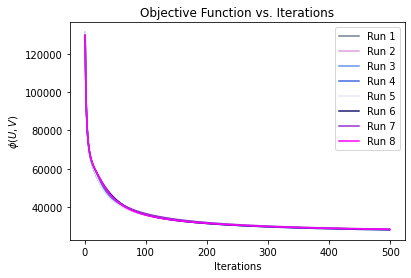

In [ ]:
plt.plot(range(1,500), objective_fxn1[1:], 'slategrey', label = 'Run 1')
plt.plot(range(1,500), objective_fxn2[1:], 'plum', label = 'Run 2')
plt.plot(range(1,500), objective_fxn3[1:], 'cornflowerblue', label = 'Run 3')
plt.plot(range(1,500), objective_fxn4[1:], 'royalblue', label = 'Run 4')
plt.plot(range(1,500), objective_fxn5[1:], 'lavender', label = 'Run 5')
plt.plot(range(1,500), objective_fxn6[1:], 'midnightblue', label = 'Run 6')
plt.plot(range(1,500), objective_fxn7[1:], 'darkorchid', label = 'Run 7')
plt.plot(range(1,500), objective_fxn8[1:], 'fuchsia', label = 'Run 8')
#plt.plot(range(1,501), objective_fxn9, 'crimson', label = 'Run 9')
#plt.plot(range(1,501), objective_fxn10, 'aqua', label = 'Run 10')
plt.legend()
plt.title('Objective Function vs. Iterations')
plt.xlabel('Iterations')
plt.ylabel('$\phi(U,V)$')

fig2 = plt.gcf()
plt.show()

# save figure
fig2.savefig('/content/drive/MyDrive/ELENE4720_ML_Signals/Homework_3/problem_1_objective.jpeg')
plt.show()

In [ ]:
#objective_fxn1[-1]
#objective_fxn2[-1]
#objective_fxn3[-1]
#objective_fxn4[-1]
#objective_fxn5[-1]
#objective_fxn6[-1]
#objective_fxn7[-1]
objective_fxn8[-1]


28331.902804047742

In [ ]:
# import the test ratings file
# ratings_test = pd.read_csv(filepath+'Prob1_ratings_test.csv', header = None)
# ratings_test
new_ratings_test = ratings_test.rename(columns={0: 'user_id', 1: 'movie_id', 2: 'rating'})
new_ratings_test
wide_ratings_test = new_ratings_test.pivot(index='user_id', columns='movie_id', values='rating')
wide_ratings_test


movie_id,1,2,3,4,5,6,7,8,9,10,...,1541,1577,1594,1600,1604,1620,1637,1643,1652,1681
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# there are no 0's in the dataframe
(wide_ratings_test == 0).sum().sum()
# so set Nan to 0, these will be the empty parts of the matrix (sparse)
wide_ratings_test = wide_ratings.replace(np.nan,0)
# check if removed all nans
(wide_ratings_test == np.nan).sum().sum()

0

In [ ]:
# extract column names (movie ID's) and index names (user ID's) from dataframes
ratings_col_names = wide_ratings.columns.values.tolist()
ratings_index_names = wide_ratings.index.values.tolist()

ratings_test_col_names = wide_ratings_test.columns.values.tolist()
ratings_test_index_names = wide_ratings_test.index.values.tolist()

In [ ]:

def calc_RMSE(full_matrix, wide_ratings_test, ratings_test_index_names, ratings_test_col_names):
  """
  Calculate RMSE based on dataframe full_matrix[run_number] and dataframe wide_matrix_test.
  Find if same user_id, movie_id in the test set is =/= 0, then takes squared error compared to the same
  indexed predicted value in full_matrix_df.

  """
  full_matrix_df = pd.DataFrame(data= full_matrix, index = ratings_index_names, columns= ratings_col_names)
  RMSE = 0
  num = 0

  for i in ratings_test_index_names:
    for j in ratings_test_col_names:
      if wide_ratings_test.loc[i,j] != 0:
          RMSE = (full_matrix_df.loc[i,j] - wide_ratings_test.loc[i,j])**2
          RMSE += RMSE
          num = num + 1

      else:
        RMSE = RMSE
        num = num

  RMSE_final = np.sqrt(RMSE)/num

  return RMSE_final

In [ ]:
RMSE_list = []

RMSE_final1 = calc_RMSE(full_matrix1, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
RMSE_list.append(RMSE_final1)

RMSE_final2 = calc_RMSE(full_matrix2, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
RMSE_list.append(RMSE_final2)

RMSE_final3 = calc_RMSE(full_matrix3, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
RMSE_list.append(RMSE_final3)

RMSE_final4 = calc_RMSE(full_matrix4, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
RMSE_list.append(RMSE_final4)

RMSE_final5 = calc_RMSE(full_matrix5, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
RMSE_list.append(RMSE_final5)

RMSE_final6 = calc_RMSE(full_matrix6, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
RMSE_list.append(RMSE_final6)

RMSE_final7 = calc_RMSE(full_matrix7, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
RMSE_list.append(RMSE_final7)

RMSE_final8 = calc_RMSE(full_matrix8, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
RMSE_list.append(RMSE_final8)

# RMSE_final9 = calc_RMSE(full_matrix9, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
# RMSE_list.append[RMSE_final9]

# RMSE_final10 = calc_RMSE(full_matrix10, wide_ratings_test, ratings_test_index_names, ratings_test_col_names)
# RMSE_list.append[RMSE_final10]

In [ ]:
RMSE_list

[3.29735450781985e-06,
 1.068714924458571e-05,
 1.113555221657035e-06,
 1.1273991458498974e-06,
 2.434078601756626e-06,
 3.5339525628847806e-06,
 4.820205491545369e-06,
 1.9219907834755354e-06]

## Question 1 (b) 2.

In [ ]:
movies = open(filepath+'Prob1_movies.txt')
movie_names =[]
for i in movies:
    movie_names.append(i)

In [ ]:
# find Star Wars, My Fair Lady, Goodfellas indeces in movie_names
star_wars = movie_names.index("Star Wars (1977)\n")
goodfellas = movie_names.index("GoodFellas (1990)\n")
my_fair_lady = movie_names.index("My Fair Lady (1964)\n")

In [ ]:
# find euclidean distances
dist_goodfellas = []
dist_star_wars = []
dist_fair_lady = []

for i in range(Q_end1.shape[0]):
  dist = math.dist(Q_end1[goodfellas,:],Q_end1[i,:])
  dist_goodfellas.append(dist)

  dist = math.dist(Q_end1[star_wars,:],Q_end1[i,:])
  dist_star_wars.append(dist)

  dist = math.dist(Q_end1[my_fair_lady,:],Q_end1[i,:])
  dist_fair_lady.append(dist)

In [ ]:
# find indeces of 10 smallest distance for each movie
# print movie name
# print other movies around it
# print distances
sort_index_goodfellas = np.argsort(dist_goodfellas)
smallest_goodfellas = sort_index_goodfellas[0:6]
print(movie_names[smallest_goodfellas[0]])
print('Similar Movie Title = ', movie_names[smallest_goodfellas[1]])
print('distance = ', dist_goodfellas[smallest_goodfellas[1]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_goodfellas[2]])
print('distance = ', dist_goodfellas[smallest_goodfellas[2]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_goodfellas[3]])
print('distance = ', dist_goodfellas[smallest_goodfellas[3]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_goodfellas[4]])
print('distance = ', dist_goodfellas[smallest_goodfellas[4]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_goodfellas[5]])
print('distance = ', dist_goodfellas[smallest_goodfellas[5]],'\n\n')

sort_index_dist_fair_lady = np.argsort(dist_fair_lady)
smallest_fair_lady = sort_index_dist_fair_lady[0:6]
print(movie_names[smallest_fair_lady[0]])
print('Similar Movie Title = ', movie_names[smallest_fair_lady[1]])
print('distance = ', dist_fair_lady[smallest_fair_lady[1]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_fair_lady[2]])
print('distance = ', dist_fair_lady[smallest_fair_lady[2]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_fair_lady[3]])
print('distance = ', dist_fair_lady[smallest_fair_lady[3]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_fair_lady[4]])
print('distance = ', dist_fair_lady[smallest_fair_lady[4]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_fair_lady[5]])
print('distance = ', dist_fair_lady[smallest_fair_lady[5]],'\n\n')

sort_index_star_wars = np.argsort(dist_star_wars)
smallest_star_wars = sort_index_star_wars[0:6]
print(movie_names[smallest_star_wars[0]])
print('Similar Movie Title = ', movie_names[smallest_star_wars[1]])
print('distance = ', dist_star_wars[smallest_star_wars[1]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_star_wars[2]])
print('distance = ', dist_star_wars[smallest_star_wars[2]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_star_wars[3]])
print('distance = ', dist_star_wars[smallest_star_wars[3]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_star_wars[4]])
print('distance = ', dist_star_wars[smallest_star_wars[4]],'\n\n')
print('Similar Movie Title = ', movie_names[smallest_star_wars[5]])
print('distance = ', dist_star_wars[smallest_star_wars[5]],'\n\n')

GoodFellas (1990)

Similar Movie Title =  Bonnie and Clyde (1967)

distance =  0.7480663606920528 


Similar Movie Title =  Godfather: Part II, The (1974)

distance =  0.8083079037881894 


Similar Movie Title =  Apocalypse Now (1979)

distance =  0.8226365723667162 


Similar Movie Title =  Quiz Show (1994)

distance =  0.9141892889357811 


Similar Movie Title =  Good, The Bad and The Ugly, The (1966)

distance =  1.0315513193232972 


My Fair Lady (1964)

Similar Movie Title =  Oscar & Lucinda (1997)

distance =  1.2078347641315574 


Similar Movie Title =  King of the Hill (1993)

distance =  1.3679829815455287 


Similar Movie Title =  Evita (1996)

distance =  1.4706860910905786 


Similar Movie Title =  Beauty and the Beast (1991)

distance =  1.4849417986547604 


Similar Movie Title =  Cinderella (1950)

distance =  1.4868084904730532 


Star Wars (1977)

Similar Movie Title =  Empire Strikes Back, The (1980)

distance =  0.425031418680749 


Similar Movie Title =  Return of t

## Question 2 (b)

In [ ]:
N = 3012
M = 8447

num_iter = 1000
rank = 25

X = np.zeros(shape=(N,M))
np.random.seed(0)
W = np.random.uniform(1,2,size=(N,rank))
H = np.random.uniform(1,2,size=(rank,M))

In [ ]:
# import files
filepath = '/content/drive/MyDrive/ELENE4720_ML_Signals/Homework_3/hw3-data/'
filename = filepath+'Prob2_nyt_data.txt'

In [ ]:
doc_index = 0
for i in open(filename,"r"):
    row = (i.strip().split(","))
    for element in row:
        temp = element.split(":")
        X[int(temp[0])-1][doc_index]= int(temp[1])
    doc_index+=1

In [ ]:
objective = []
for run in range(num_iter):
    X_WH = np.divide(X,(np.matmul(W,H)+10**-6))
    W_T = W.T
    row_sums = np.sum(W_T,axis=1)
    normalized_W_T =  W_T / (row_sums[:, np.newaxis] + 10**-6)
    second_term = np.matmul(normalized_W_T,X_WH)
    H = np.multiply(H,(second_term))
    
    X_WH = np.divide(X,(np.matmul(W,H)+10**-6))
    H_T = H.T
    col_sums = np.sum(H_T,axis=0)
    normalized_H_T =  H_T / (col_sums + 10**-6)
    second_term = np.matmul(X_WH,normalized_H_T)
    W = np.multiply(W,(second_term))
    
    WH = np.matmul(W,H)
    log_WH = np.log(WH+ 10**-6) 
    temp = np.multiply(X,log_WH) - WH
    objective_value = -np.sum(temp)
    objective.append(objective_value)

In [ ]:
plt.plot(range(1,1001),objective)
plt.title("Objective Fxn vs. Iterations")
plt.xlabel("Iterations")
plt.ylabel('$\phi(W,H) = 1/2 || WH-X ||^2_F + I_{W>0} + I_{H>0}$')
plt.show()
fig1 = plt.gcf()
plt.show()

# save figure
fig1.savefig('/content/drive/MyDrive/ELENE4720_ML_Signals/Homework_3/problem_2_objective.jpeg')
plt.show()

## Question 2 (c)

In [ ]:
col_sums = np.sum(W,axis=0)
normalized_W =  W / (col_sums + 10**-16)

In [ ]:
# import files
filepath = '/content/drive/MyDrive/ELENE4720_ML_Signals/Homework_3/hw3-data/'
filename = filepath+'Prob2_nyt_vocab.dat'

In [ ]:
names=[]
for i in open(filename,"r"):
    names.append(i.strip())
names=np.array(names)

In [ ]:
positions = dict()
values = dict()
list_topic_word = dict()
for i in range(rank):
    positions[i] = np.argsort(-normalized_W[:,i])
    positions[i] = positions[i].tolist()[:10]
    positions[i] = [names[j] for j in positions[i]]
    values[i] = -np.sort(-normalized_W[:,i])
    values[i] = values[i].tolist()[:10]

In [ ]:
answer = dict()
for i in range(25):
    text=""
    for j in range(10):
        text+= positions[i][j] + " : " +str(round(values[i][j],4)*1000) + "\n"
    answer[i]=text[:-1]

In [ ]:
for i in range(25):
    print(i+1)
    print("---------------------------")
    print(answer[i])
    print("---------------------------")